Slab Subduction
======

This two dimensional subduction model has a dense, high viscosity 3 layered plate overlying a lower viscosity mantle. The upper and lower plate layers have a visco-plastic rheology, yielding under large stresses. The middle, core layer has a viscous only rheology, maintaining strength during bending. The top 1000 km of the mantle is included, the upper & lower mantle is partitioned with a viscosity contrast of 100x at 600 km depth. The velocity boundary conditions on the domain are free-slip/mirror (a closed box, not open or periodic). 

**This lesson introduces the concepts of:**
1. realistic material rheologies 

**References**

1. OzBench, M.; Regenauer-Lieb, K.; Stegman, D. R.; Morra, G.; Farrington, R.; Hale, A.; May, D. A.; Freeman, J.; Bourgouin, L.; Mühlhaus, H. & Moresi, L. A model comparison study of large-scale mantle-lithosphere dynamics driven by subduction. Physics of the Earth and Planetary Interiors, 2008, 171, 224-234. [OzBench, 2008](http://www.sciencedirect.com/science/article/pii/S0031920108002318)

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os

Setup parameters
-----

Set simulation and physical values - the simulation resolution in ``x`` and ``y`` directions, number of dimensions (*dim*) and aspect ratio.

In [2]:
xRes = 96   # looks good for 96x48
yRes = 48
dim  = 2
boxLength = 4.0
boxHeight = 1.0

mantleDensity = 0.0
slabDensity  = 1.0 

lowerMantleViscosity = 100.0
upperMantleViscosity = 1.0
slabViscosity = 200.0
coreViscosity = 2000.0

outputPath = "./Subduction2D/"
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

Create mesh and finite element variables
------

The velocity and pressure is calculated on a mesh, for our purposes this is a defined 2D cartesian mesh.
The mesh objects are created, storing the indices and spatial coordiates of the grid points on the mesh.  

Finite Element (FE) variables for the velocity and pressure fields. The velocity field contains a vector of *dim* dimensions at each mesh point, while the pressure needs only a single value as it is a scalar field.

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight) ) 

velocityField   = uw.fevariable.FeVariable( feMesh=mesh,         nodeDofCount=dim )
pressureField   = uw.fevariable.FeVariable( feMesh=mesh.subMesh, nodeDofCount=1 )

Create a particle swarm
------

Swarms refer to (large) groups of particles which can advect with the fluid flow through the finite elements. These can be used to determine 'materials' as they can carry local information such as the fluid density and viscosity.

Underworld uses these when the local fluid density is calculated on the mesh, which in turn affects the fluid velocity, and subsequently the advection of the particle swarm.

In [4]:
# initialise a swarm
swarm = uw.swarm.Swarm( feMesh=mesh )

# add a data variable which will store information on the particle
materialVariable   = swarm.add_variable( dataType="int", count=1 )

# create a layout object that will populate the swarm across the whole domain
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# activate the layout object
swarm.populate_using_layout( layout=swarmLayout )

**Allocate materials to particles**

Each particle in the swarm can be given individual values, such as viscosity and density.
For our model we have 4 different materials - the Upper Mantle, Lower Mantle, Upper Slab, Lower Slab.

In [5]:
# initialise the 'materialVariable' data to represent two different materials. 
upperMantleIndex = 0
lowerMantleIndex = 1
upperSlabIndex   = 2
lowerSlabIndex   = 3
coreSlabIndex    = 4

# Initial material layout has a flat lying slab with at 15\degree perturbation
lowerMantleY   = 0.4
slabLowerShape = np.array([ (1.2,0.925 ), (3.25,0.925 ), (3.20,0.900), (1.2,0.900), (1.02,0.825), (1.02,0.850) ])
slabCoreShape  = np.array([ (1.2,0.975 ), (3.35,0.975 ), (3.25,0.925), (1.2,0.925), (1.02,0.850), (1.02,0.900) ])
slabUpperShape = np.array([ (1.2,1.000 ), (3.40,1.000 ), (3.35,0.975), (1.2,0.975), (1.02,0.900), (1.02,0.925) ])

slabLower = fn.shape.Polygon( slabLowerShape )
slabUpper = fn.shape.Polygon( slabUpperShape )
slabCore  = fn.shape.Polygon( slabCoreShape )

# initialise everying to be upper mantle material
materialVariable.data[:] = upperMantleIndex

# change matieral index if the particle is in the lower mantle or slab shape
for particleID in range( swarm.particleCoordinates.data.shape[0] ):
    if swarm.particleCoordinates.data[particleID][1] < lowerMantleY:
        materialVariable.data[particleID]     = lowerMantleIndex
    if slabCore.evaluate(tuple(swarm.particleCoordinates.data[particleID])):
            materialVariable.data[particleID] = coreSlabIndex
    if slabUpper.evaluate(tuple(swarm.particleCoordinates.data[particleID])):
            materialVariable.data[particleID] = upperSlabIndex
    elif slabLower.evaluate(tuple(swarm.particleCoordinates.data[particleID])):
            materialVariable.data[particleID] = lowerSlabIndex

Hottub time finish!!


**Plot the initial positions for the particle swarm and colour by material type**


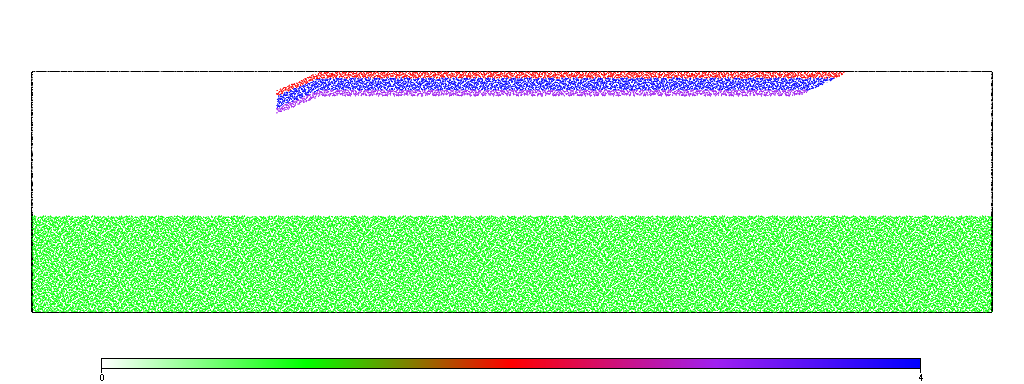

In [6]:
figParticle = glucifer.Figure( figsize=(1024,384) )
figParticle + glucifer.objects.Points( swarm, materialVariable, pointSize=2, colours='white green red purple blue' )
figParticle.show()

Set up material parameters and functions
----

Here the functions for density, viscosity, gravity and buoyancy are set. 

**Viscosity function**

The lower mantle is 100x more viscous than the upper mantle. 
The upper slab layer weakens under high strain, it has a visco plastic rheology.  The lower slab layer does not yield, it is purely viscous.  

In [7]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.gradientFn ))
cohesion = 0.06
vonMises = cohesion / strainRate_2ndInvariant

# The upper slab viscosity is the minimum of the 'slabViscosity' or the 'vonMises' 
slabYieldvisc = fn.exception.SafeMaths( fn.misc.min(vonMises, slabViscosity) )

# Viscosity function for the materials 
viscosityMap = { upperMantleIndex : upperMantleViscosity, 
                 lowerMantleIndex : lowerMantleViscosity, 
                 upperSlabIndex   : slabYieldvisc, 
                 lowerSlabIndex   : slabYieldvisc,
                 coreSlabIndex    : coreViscosity}
viscosityMapFn = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )

Note: ``SafeMaths`` in the above cell refers to a function which checks the value passed inside for any infinite or other not-a-number type errors.

**Initial linear viscosity **

The upper slab viscosity is dependent on the velocity field. 
It will return an error if velocity = 0.
We will provide an initial linear viscosity for the very first solve.


In [8]:
viscosityMap_init = { upperMantleIndex : upperMantleViscosity, 
                      lowerMantleIndex : lowerMantleViscosity, 
                      upperSlabIndex   : slabViscosity, 
                      lowerSlabIndex   : slabViscosity,
                      coreSlabIndex    : coreViscosity}
viscosityMapFn_init = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap_init )

**Set the density function, vertical unit vector and Buoyancy Force function**


In [9]:
densityMap = { upperMantleIndex : mantleDensity, 
               lowerMantleIndex : mantleDensity, 
               upperSlabIndex   : slabDensity, 
               lowerSlabIndex   : slabDensity, 
               coreSlabIndex    : slabDensity}
densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Define our vertical unit vector using a python tuple
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector
buoyancyFn = -1.0 * densityFn * z_hat

Set initial and boundary conditions
------
Set up ``iWalls`` (vertical) and ``JWalls`` (horizontal) boundary walls. Use a freeslip velocity boundary condition function.


In [10]:
# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               nodeIndexSets = (iWalls, jWalls) )


System Setup
----------

**Setup a Stokes system**

In this system the velocity field, pressure, viscosity and buoyancy forces need to be passed to the Stokes system function. Along with the conditions affecting these variables - in this case the freeslip boundary conditions for the velocity field.

This system is solved after each time step using the .solve function (see main loop below).

We need to first set up the initial solve (stokesPIC_init) with the linear visocity.  The non linear stokes system will be created later.

In [11]:
# Initial linear slab viscosity setup
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               swarm         = swarm, 
                               conditions    = [freeslipBC,],
                               viscosityFn   = viscosityMapFn_init, 
                               bodyForceFn   = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokesPIC)
solver.solve()

In [12]:
# Change viscosityFN to non-linear upper slab viscosity version
stokesPIC.viscosityFn = viscosityMapFn
# Re-solve 
solver.solve(nonLinearIterate=True)

**Create a system to advect the particles**

This makes sure the particle move about the velocity field.

The velocity field variable which will advect the particles in the swarm around the box. We also specify the order of integration for solving the equations, in this case second order integration.

In [13]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Analysis tools
-----

Set up some useful outputs that will be evaluated in the main simulation time loop. Also set up some output figures that will be saved in the main loop.

**The root mean square Velocity**

In [14]:
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

**Plot of particles density**


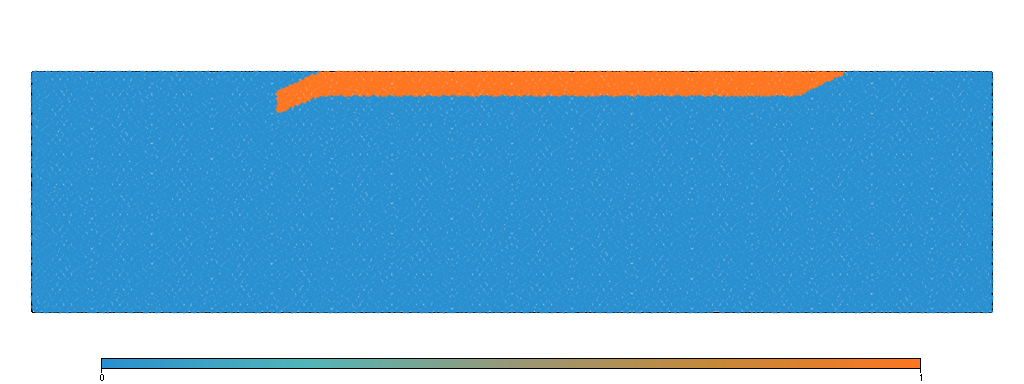

In [15]:
figDensity = glucifer.Figure( figsize=(1024,384) )
figDensity + glucifer.objects.Points( swarm, densityFn, pointSize=4 )
figDensity.show()

**Plot of Velocity Magnitude**


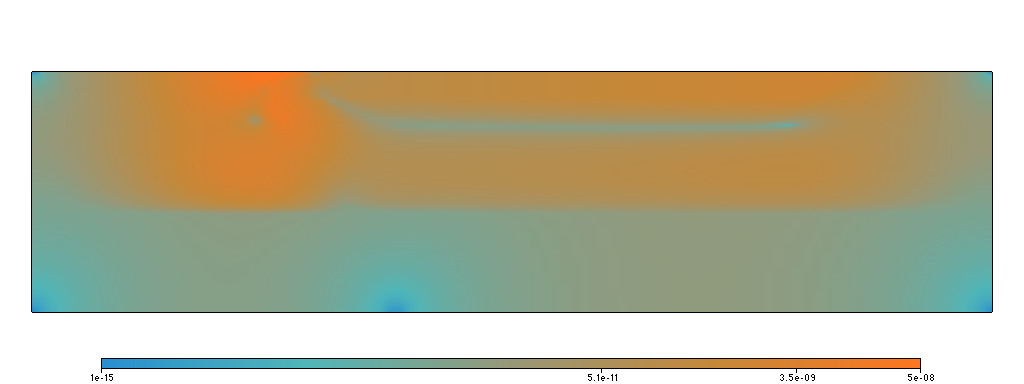

In [16]:
figVelocityMag = glucifer.Figure(figsize=(1024,384))
figVelocityMag + glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField), logScale=True, valueRange=[1e-15,5e-8])
figVelocityMag.show()

**Plot of Strain Rate, 2nd Invariant**


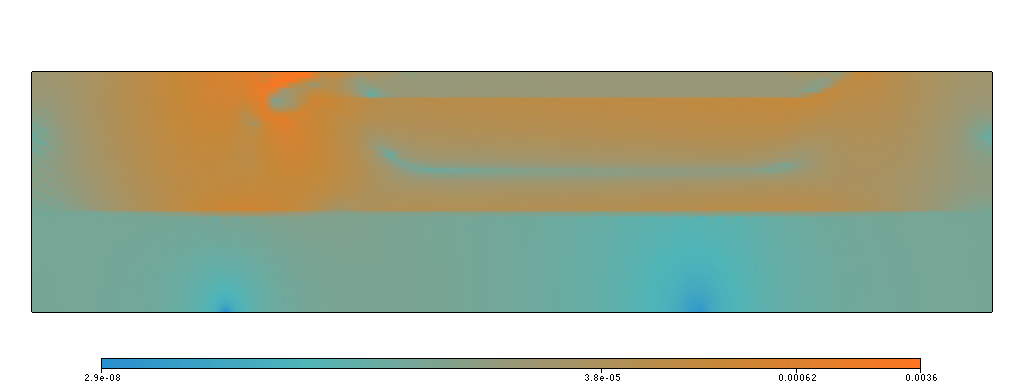

In [17]:
figStrainRate = glucifer.Figure(figsize=(1024,384))
figStrainRate + glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True)
figStrainRate.show()

**Plot of particles viscosity**


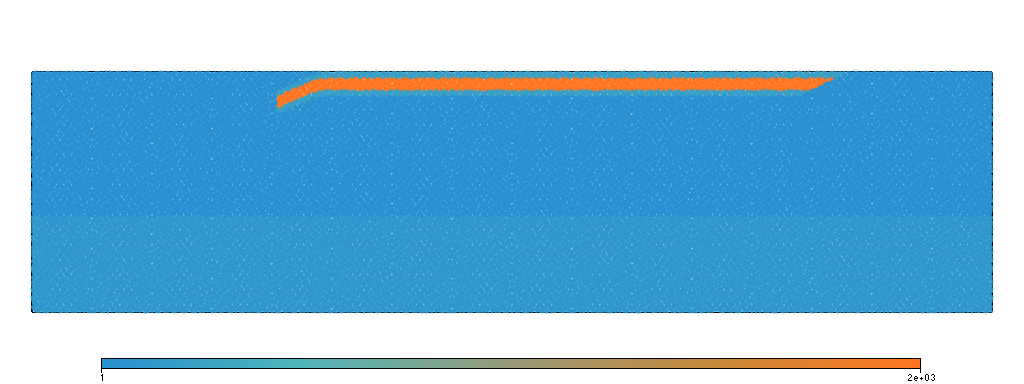

In [18]:
figViscosity = glucifer.Figure(figsize=(1024,384))
figViscosity + glucifer.objects.Points(swarm, viscosityMapFn, pointSize=4)
figViscosity.show()

**Plot of Stress Invariant**


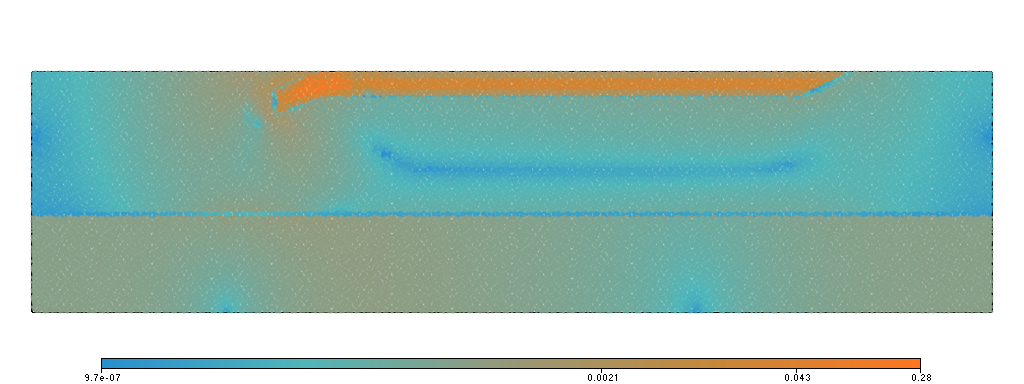

In [19]:
figStress = glucifer.Figure( figsize=(1024,384) )
figStress + glucifer.objects.Points( swarm, viscosityMapFn*strainRate_2ndInvariant, pointSize=4, logScale=True )
figStress.show()

Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [20]:
time = 0.  # Initial time
step = 0   # Initial timestep
maxSteps = 11  # Maximum timesteps (201 is recommended)
steps_output = 10   # output every 5 timesteps

while step < maxSteps:
    # Solve non linear Stokes system
    stokesPIC.solve(nonLinearIterate = True)  
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size
    advector.integrate(dt)
    # output figure to file at intervals = steps_output
    if step == 0 or step % steps_output == 0:
        ## this output path isn't working
        figParticle.save_image(    outputPath + "slabImage_particle"    + str(step).zfill(4))
        figVelocityMag.save_image( outputPath + "slabImage_velocityMag" + str(step).zfill(4))
        figStrainRate.save_image(  outputPath + "slabImage_strainRate"  + str(step).zfill(4))
        figViscosity.save_image(   outputPath + "slabImage_viscosity"   + str(step).zfill(4))
        figStress.save_image(      outputPath + "slabImage_stress"      + str(step).zfill(4))
        figDensity.save_image(     outputPath + "slabImage_density"     + str(step).zfill(4))
    # Output time step, time, Vrms and CPUtime.  
    print 'step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}'.format(step,time,Vrms)
    # Increment time and timestep
    time += dt
    step += 1


step =      0; time = 0.000e+00; Vrms = 1.817e-05
step =      1; time = 4.703e+01; Vrms = 1.817e-05
step =      2; time = 9.396e+01; Vrms = 1.817e-05
step =      3; time = 1.419e+02; Vrms = 1.817e-05
step =      4; time = 1.905e+02; Vrms = 1.817e-05
step =      5; time = 2.459e+02; Vrms = 1.817e-05
step =      6; time = 3.071e+02; Vrms = 1.817e-05
step =      7; time = 3.698e+02; Vrms = 1.817e-05
step =      8; time = 4.313e+02; Vrms = 1.817e-05
step =      9; time = 4.961e+02; Vrms = 1.817e-05
step =     10; time = 5.671e+02; Vrms = 1.817e-05


Post simulation analysis
-----

Plot all figures for the resulting system.


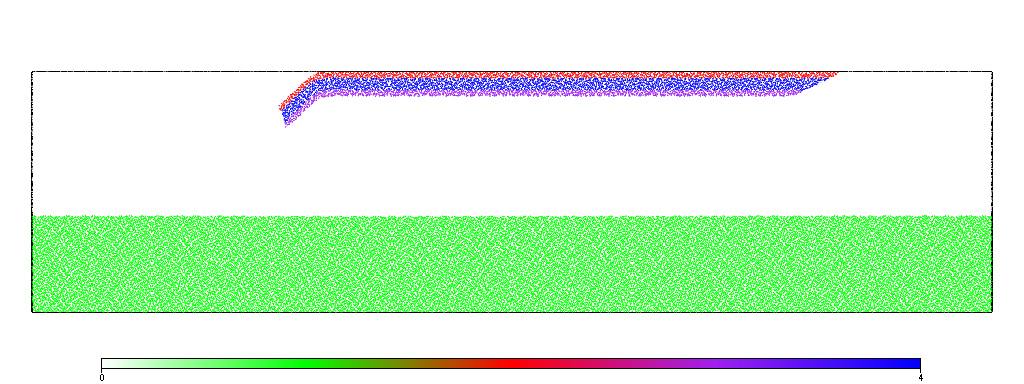

In [21]:
figParticle.show()


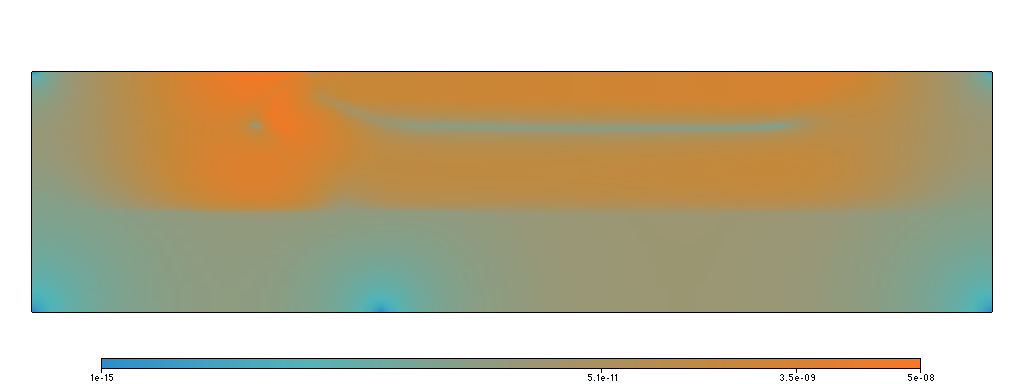

In [22]:
figVelocityMag.show()


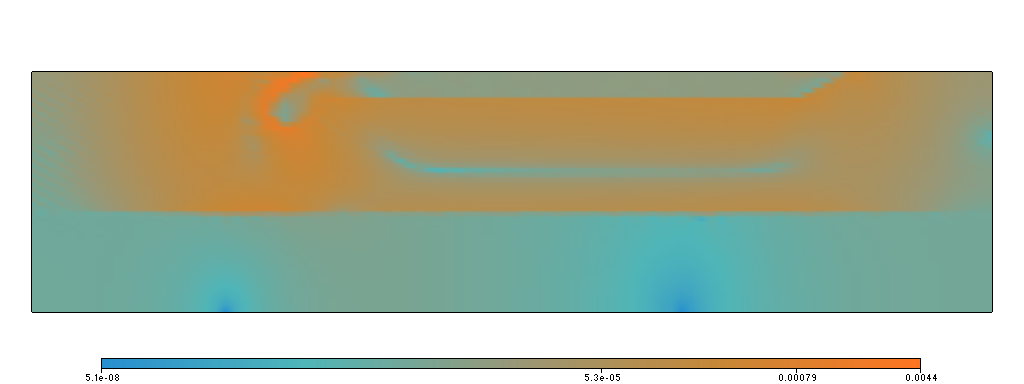

In [23]:
figStrainRate.show()


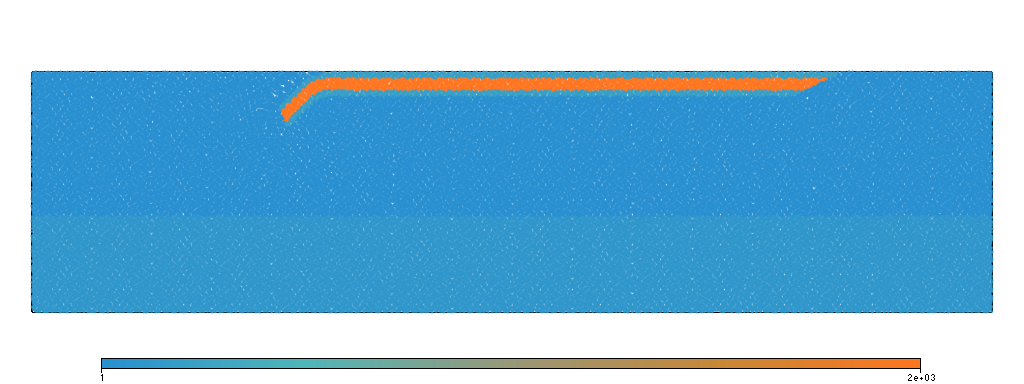

In [24]:
figViscosity.show()


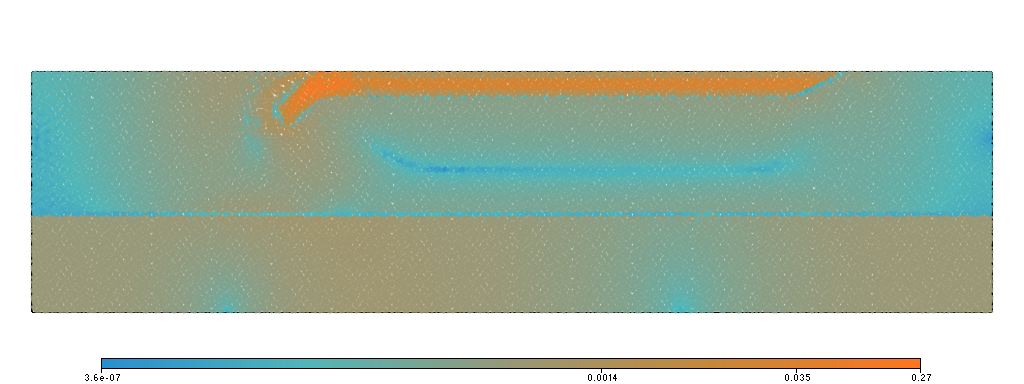

In [25]:
figStress.show()


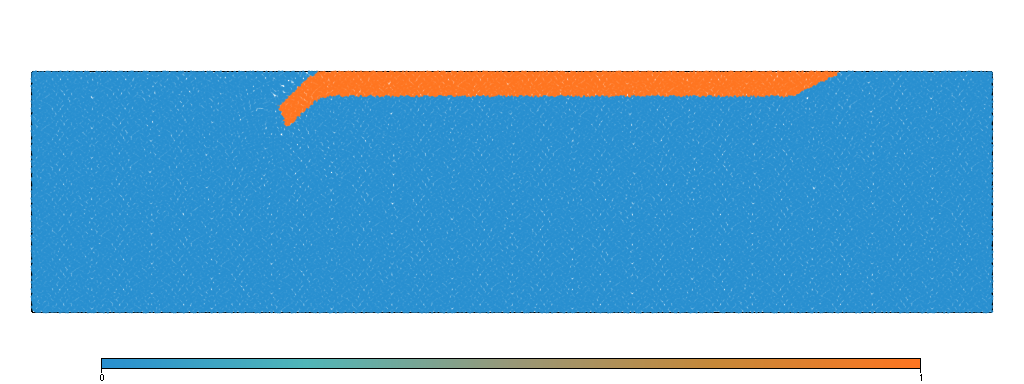

In [26]:
figDensity.show()